# Call Reports Analysis

##### Housekeeping and loading data

In [2]:
# Load packages
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/clean'
path_output = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/output'

# Set path to be the directory:
os.chdir(path)

In [4]:
fed_funds = pd.read_csv('FEDFUNDS.csv', parse_dates = ['DATE'])

# Rename 'DATE' to 'Date' in fed_funds:
fed_funds = fed_funds.rename(columns = {'DATE':'Date'})

# Divide FEDFUNDS by 100 to get the interest rate in percentage terms:
fed_funds['FEDFUNDS'] = fed_funds['FEDFUNDS']/100

In [5]:
# Make the dates in fed_funds to be the last day of the previous month:
fed_funds['Date'] = fed_funds['Date'] - pd.DateOffset(days = 1)

In [6]:
# Read file that contains only the variables of interest, specify that the column 'Date' is a date:
main = pd.read_csv('call_reports.csv', parse_dates = ['Date'])

C:\Users\angel\AppData\Local\Temp\ipykernel_9572\914245168.py:2: DtypeWarning: Columns (31,72,234,271,282,545,701,704,707,708,709,710,711,712,717,718,719,724,727,730,731,732,733,734,735,740,741,742,762,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928) have mixed types. Specify dtype option on import or set low_memory=False.
  main = pd.read_csv('call_reports.csv', parse_dates = ['Date'])


In [7]:
# drop all columns in main that start with 'Unnamed':
main = main.loc[:, ~main.columns.str.contains('^Unnamed')]

main['Year'] = main['Date'].dt.year

In [8]:
# merge the data:
main  = pd.merge(main, fed_funds, how = 'left', on = 'Date').sort_values(by = ['IDRSSD', 'Date'])

In [9]:
transformations = pd.read_csv('CSV_TRANSFORMATIONS.csv')

In [10]:
# load data on mergers and acquisitions:
transformations = pd.read_csv('CSV_TRANSFORMATIONS.csv')

# rename the columns:
transformations = transformations.rename(columns={'#ID_RSSD_PREDECESSOR': 'Predecessor ID', 
                                                  'ID_RSSD_SUCCESSOR': 'Successor ID',
                                                 'DT_TRANS': 'Transaction Date',
                                                 'TRNSFM_CD': 'Transaction Code',})

# convert the 'transaction_date' to datetime format:
transformations['Transaction Date'] = pd.to_datetime(transformations['Transaction Date'], format='%Y%m%d')
transformations = transformations[['Predecessor ID', 'Successor ID', 'Transaction Date', 'Transaction Code']]


##### Basic Definitions

###### Balance sheet definitions

In [11]:
# create 'Total Assets' variable. If the bank fills the FFIEC41 (only RCON series available). Large banks may also have the 
# RCFD series available. If both are NaN, fill with NaN. If both are available, use the RCON series. If only RCFD is available,
# use RCFD. 
main['Total Assets'] = main['RCON2170'].combine_first(main['RCFD2170'])

print(main['RCON2170'].describe())
print(main['RCFD2170'].describe())
print(main['Total Assets'].describe())

main['Total Assets'] = main['Total Assets'].mask(main['Total Assets'] == 0, np.nan)

count    6.261330e+05
mean     9.698809e+05
std      1.251680e+07
min      0.000000e+00
25%      6.915500e+04
50%      1.506950e+05
75%      3.632950e+05
max      1.445545e+09
Name: RCON2170, dtype: float64
count    9.425000e+03
mean     1.016951e+08
std      3.093355e+08
min      4.264000e+03
25%      1.437040e+06
50%      1.221104e+07
75%      6.568676e+07
max      3.503360e+09
Name: RCFD2170, dtype: float64
count    6.307380e+05
mean     2.068706e+06
std      3.861057e+07
min      0.000000e+00
25%      6.962000e+04
50%      1.522710e+05
75%      3.717335e+05
max      3.503360e+09
Name: Total Assets, dtype: float64


In [12]:
# create 'Total Deposits'
main.rename(columns = {'RCON2200':'Total Deposits'}, inplace = True)
main['Total Deposits'] = main['Total Deposits'].mask(main['Total Deposits'] == 0, np.nan)
print(main['Total Deposits'].describe())

count    6.242610e+05
mean     1.424842e+06
std      2.496490e+07
min      1.000000e+00
25%      5.904900e+04
50%      1.283820e+05
75%      3.082980e+05
max      2.201118e+09
Name: Total Deposits, dtype: float64


In [13]:
# create 'Cash' summing RCON0020 and RCON0080:
main['Cash'] = main['RCON0010'].combine_first(main['RCON0071']+main['RCON0081'])
main['Cash'] = main['Cash'].mask(main['Cash'] <= 0, np.nan)
print(main['Cash'].describe())

count    6.299250e+05
mean     1.673560e+05
std      4.188713e+06
min      1.000000e+00
25%      3.340000e+03
50%      8.333000e+03
75%      2.219700e+04
max      5.436850e+08
Name: Cash, dtype: float64


In [15]:
# create 'Securities AC' summing RCON1754 and RCON1772. If both are NaN, fill with NaN. If only one is available, use that one. If both 
# are available sum them:
main['Securities AC'] = main[['RCON1754', 'RCON1772']].apply(
    lambda row: np.nan if pd.isna(row['RCON1754']) and pd.isna(row['RCON1772']) else (row.fillna(0).sum()),
    axis=1
)
main['Securities AC'] = main['Securities AC'].mask(main['Securities AC'] <= 0, np.nan)
print(main['Securities AC'].describe())

count    5.747550e+05
mean     1.759930e+05
std      4.215933e+06
min      1.000000e+00
25%      1.025950e+04
50%      2.694200e+04
75%      7.029350e+04
max      6.830540e+08
Name: Securities AC, dtype: float64


In [91]:
# compute the 'Deposit Share' of each bank, per 'Date':
main.loc[:,'Deposit Share'] = main['Total Deposits']/main.groupby('Date')['Total Deposits'].transform('sum')
print(main['Deposit Share'].describe())

count    5.706290e+05
mean     1.629780e-04
std      1.545800e-03
min      4.578187e-10
25%      1.983403e-05
50%      4.220800e-05
75%      9.658388e-05
max      1.487919e-01
Name: Deposit Share, dtype: float64


###### Income Definitions

In [66]:
# compute the variable above avoiding the SettingWithCopyWarning:
main.loc[:, 'Deposit Expenditure'] = (main['RIAD4073'].fillna(0) - main['RIAD4200'].fillna(0) - main['RIAD4185'].fillna(0) - 
                                      main['RIAD4180'].fillna(0) - main['RIAD4172'].fillna(0))

In [70]:
main.loc[:, 'Actual Deposit Exp'] = main.groupby(['IDRSSD', 'Year'])['Deposit Expenditure'].diff().fillna(main['Deposit Expenditure'])
main.loc[:, 'Actual Deposit Exp'] = main['Actual Deposit Exp'].mask(main['Actual Deposit Exp'] <= 0, np.nan)
main['Actual Deposit Exp'].describe()

count    5.685320e+05
mean     2.013608e+03
std      4.547533e+04
min      1.000000e+00
25%      1.540000e+02
50%      3.730000e+02
75%      9.320000e+02
max      9.013000e+06
Name: Actual Deposit Exp, dtype: float64

In [76]:
# Compute deposit rates:
main.loc[:,'Deposit Rate'] = main['Actual Deposit Exp'] / main['Total Deposits']
print(main['Deposit Rate'].describe())
main.loc[:,'Deposit Spread'] = -main['Deposit Rate'] + main['FEDFUNDS']
print(main['Deposit Spread'].describe())

count    5.685320e+05
mean     3.738512e-03
std      1.190860e-02
min      1.480123e-07
25%      1.317913e-03
50%      2.927841e-03
75%      5.410877e-03
max      2.780000e+00
Name: Deposit Rate, dtype: float64
count    568532.000000
mean          0.012838
std           0.019852
min          -2.731700
25%          -0.000136
50%           0.007120
75%           0.021478
max           0.053292
Name: Deposit Spread, dtype: float64


In [20]:
balanced_panel = 0

if balanced_panel == 1:

    # Step 1: Count the total number of unique dates in the dataset
    total_dates = main['Date'].nunique()
    print('Number of dates:', total_dates)

    # Step 2: Count the number of unique dates each bank shows up
    bank_date_counts = main[main['Total Deposit'] > 0].groupby('IDRSSD')['Date'].nunique()
    print('Banks that show up in all dates:', sum(bank_date_counts==total_dates))

    # Step 3: Identify banks that are present in all dates with positive 'Total Deposit':
    banks = bank_date_counts[bank_date_counts == total_dates].index
    main = main[main['IDRSSD'].isin(banks)]


In [82]:
# Create an extra column in df3 with the avg. deposit rate per Date:
main.loc[:,'Avg. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('mean')
main.loc[:,'Std. Deposit Rate'] = main.groupby('Date')['Deposit Rate'].transform('std')
main.loc[:,'R_hat'] = (main['Deposit Rate'] - main['Avg. Deposit Rate']) / main['Std. Deposit Rate']
main['R_hat'].describe()

count    5.685320e+05
mean    -4.799174e-18
std      9.999191e-01
min     -5.220593e+00
25%     -4.023155e-01
50%     -3.111962e-02
75%      2.940409e-01
max      8.601587e+01
Name: R_hat, dtype: float64

In [94]:
def compute_deposit_growth(df, transformations, window=1):
    """
    Compute the log difference of deposits while accounting for mergers, acquisitions, and failures.

    Args:
    - df (pd.DataFrame): Dataframe containing bank-level balance sheet data.
    - transformations (pd.DataFrame): Dataframe containing information about transformations.
    - window (int): Number of quarters before and after a transaction to set as NaN for growth rate.

    Returns:
    - pd.DataFrame: The updated 'df' with a 'deposit_growth' column.
    """
    # Sort the dataframe by bank ID and date to ensure proper lag calculation
    df = df.sort_values(by=['IDRSSD', 'Date'])
    
    # Calculate log difference (log growth rate) of deposits
    df['Deposit_Growth'] = df.groupby('IDRSSD')['Total Deposits'].transform(lambda x: np.log(x).diff())   
    
    # Create a mask to identify rows to be set to NaN
    for _, row in transformations.iterrows():
        predecessor_id = row['Predecessor ID']
        successor_id = row['Successor ID']
        transaction_date = row['Transaction Date']
        
        # Identify date range around the transaction
        start_date = transaction_date - pd.DateOffset(months=3 * window)
        end_date = transaction_date + pd.DateOffset(months=3 * window)
        
        # Apply NaN to the specified window for predecessor and successor banks
        df.loc[
            ((df['IDRSSD'] == predecessor_id) | (df['IDRSSD'] == successor_id)) & 
            (df['Date'].between(start_date, end_date)),
            'Deposit_Growth'
        ] = np.nan
    
    return df


## Deposits

##### Tracking deposits

In [92]:
df = main[[ 'IDRSSD', 'Date', 'Financial Institution Name',             # Dates and IDS 
            'Total Deposits', 'Deposit Share', 'Total Assets',          # Bank specific quantity variables
            'Deposit Rate', 'Deposit Spread',                           # Bank specific rate variable
            'Aggregate Deposits',                                       # Aggregate quantity variables 
            'FEDFUNDS',                                                 # Aggregate rate variables
            ]]

In [95]:
df = compute_deposit_growth(df, transformations, window=1)

In [101]:
print(df['Deposit_Growth'].describe())
print(df['Deposit_Growth'].quantile([0.01, 0.99]))

count    545295.000000
mean          0.017889
std           0.097916
min          -9.242808
25%          -0.013441
50%           0.010485
75%           0.038699
max           8.391865
Name: Deposit_Growth, dtype: float64
0.01   -0.116221
0.99    0.244062
Name: Deposit_Growth, dtype: float64


In [ ]:
df['Log_Total_Assets'] = np.log(df['Total Assets'])

In [ ]:
df['Large_Banks'] = 0
df.loc[df['Total Assets'] > 2.5e9, 'Large_Banks'] = 1

In [ ]:
df.rename(columns = {'Deposit Share': 'Deposit_Share', 
                     'Deposit Rate': 'Deposit_Rate', 
                     'Deposit Spread': 'Deposit_Spread',
                     'Large TD Share': 'Uninsured_TD_Share',
                     'Deposit Maturity': 'Deposit_Maturity'}, inplace = True)

In [ ]:
df['Deposit_Growth'] = df['Deposit_Growth'].mask((df['Deposit_Growth'] <= df['Deposit_Growth'].quantile(0.01)) | 
                (df['Deposit_Growth'] >= df['Deposit_Growth'].quantile(0.99)))

In [ ]:
predecessor_id=802866

# Filter the specific transformation row for the given predecessor_id
transformation_row = transformations[transformations['Predecessor ID'] == predecessor_id]

transaction_date = transformation_row['Transaction Date'].iloc[0]

In [ ]:
successor_id = transformation_row['Successor ID'].iloc[0]

# Exclude the predecessor and successor banks
excluded_banks = {predecessor_id, successor_id}
df_filtered = df[~df['IDRSSD'].isin(excluded_banks)]

# what is the closest date before the 'transaction_date' in 'df_filtered':
closest_date = df_filtered[df_filtered['Date'] < transaction_date]['Date'].max()

df_filtered['After_Event'] = 0
df_filtered.loc[df_filtered['Date'] > transaction_date, 'After_Event'] = 1

C:\Users\angel\AppData\Local\Temp\ipykernel_20556\1478040371.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['After_Event'] = 0


In [ ]:
gainers = df_filtered[(df_filtered['After_Event']==1) & (df_filtered['Deposit_Growth']>0)]['IDRSSD']
losers = df_filtered[(df_filtered['After_Event']==1) & (df_filtered['Deposit_Growth']<0)]['IDRSSD']

In [ ]:
# banks that gained deposits after the event:
df_gainers = df_filtered[df_filtered['IDRSSD'].isin(gainers)]
df_losers = df_filtered[df_filtered['IDRSSD'].isin(losers)]

In [ ]:
print('Banks that gained deposits after SVB had:',
      df_gainers[df_gainers['Date']==closest_date]['Total Assets'].mean() / df_losers[df_losers['Date']==closest_date]['Total Assets'].mean()-1, 
      'more assets right before the event')

print('Deposit rate of gainers right after SVB:', df_gainers[df_gainers['Date']==closest_date]['Deposit_Rate'].mean())
print('Deposit rate of losers right after SVB:', df_losers[df_losers['Date']==closest_date]['Deposit_Rate'].mean())


Banks that gained deposits after SVB had: 0.05150640618197366 more assets right before the event
Deposit rate of gainers right after SVB: 0.003779501795278209
Deposit rate of losers right after SVB: 0.0036217015320686983


In [ ]:
model = smf.ols('Deposit_Growth ~ After_Event*(Log_Total_Assets+Deposit_Spread) + C(IDRSSD) + C(Date)', data = df_filtered).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Deposit_Growth   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2.297
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           5.42e-33
Time:                        08:30:34   Log-Likelihood:                 10165.
No. Observations:                7641   AIC:                        -1.967e+04
Df Residuals:                    7312   BIC:                        -1.739e+04
Df Model:                         328                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -0.2366      0.048     -4.934      0.000      -0.331      -0.143
C(IDRSSD)[T.14409.0]                           -0.0095      0.017     -0.557      0.578      -0.043       0.024
C(IDRSSD)[T.30810.0]                            0.0083      0.013      0.623      0.534      -0.018       0.034
C(IDRSSD)[T.35301.0]                           -0.0165      0.011     -1.467      0.143      -0.038       0.006
C(IDRSSD)[T.40305.0]                            0.0096      0.024      0.396      0.692      -0.038       0.057
C(IDRSSD)[T.42541.0]                           -0.0036      0.017     -0.203      0.839      -0.038       0.031
C(IDRSSD)[T.43173.0]                            0.0221      0.018      1.231      0.218      -0.013       0.057
C(IDRSSD)[T.44134.0]                            0.0354      0.016      2.190      0.029       0.004       0.067
C(IDRSSD)[T.44602.0]                           -0.0294      0.027     -1.108      0.268      -0.081       0.023
C(IDRSSD)[T.49362.0]                           -0.0037      0.039     -0.094      0.925      -0.080       0.073
C(IDRSSD)[T.53033.0]                            0.0409      0.018      2.314      0.021       0.006       0.076
C(IDRSSD)[T.56557.0]                            0.0198      0.020      1.006      0.314      -0.019       0.058
C(IDRSSD)[T.58243.0]                            0.0230      0.015      1.498      0.134      -0.007       0.053
C(IDRSSD)[T.60143.0]                           -0.0205      0.011     -1.903      0.057      -0.042       0.001
C(IDRSSD)[T.63069.0]                            0.0074      0.011      0.674      0.500      -0.014       0.029
C(IDRSSD)[T.64619.0]                            0.0387      0.015      2.584      0.010       0.009       0.068
C(IDRSSD)[T.65513.0]                            0.0378      0.017      2.213      0.027       0.004       0.071
C(IDRSSD)[T.66015.0]                            0.0617      0.018      3.428      0.001       0.026       0.097
C(IDRSSD)[T.66855.0]                         4.217e-14   1.25e-14      3.383      0.001    1.77e-14    6.66e-14
C(IDRSSD)[T.67311.0]                           -0.0044      0.039     -0.112      0.910      -0.081       0.072
C(IDRSSD)[T.75633.0]                           -0.0126      0.011     -1.126      0.260      -0.035       0.009
C(IDRSSD)[T.76201.0]                           -0.0472      0.021     -2.234      0.026      -0.089      -0.006
C(IDRSSD)[T.83638.0]                            0.0275      0.012      2.213      0.027       0.003       0.052
C(IDRSSD)[T.98717.0]                            0.0633      0.026      2.445      0.015       0.013       0.114
C(IDRSSD)[T.101019.0]                           0.0239     

In [ ]:
df_filtered['Post1'] = 0
df_filtered.loc[(df_filtered['Date'] >= transaction_date) & (df['Date'] < transaction_date + pd.DateOffset(months=3)), 'Post1'] = 1

df_filtered['Post2'] = 0
df_filtered.loc[(df_filtered['Date'] >= transaction_date ) & 
                (df_filtered['Date'] < transaction_date + pd.DateOffset(months=6)), 'Post2'] = 1

df_filtered['Post3'] = 0
df_filtered.loc[(df_filtered['Date'] >= transaction_date ) & 
                (df_filtered['Date'] < transaction_date + pd.DateOffset(months=12)), 'Post3'] = 1

# create the 'Pre1', 'Pre2', 'Pre3' variables:
df_filtered['Pre1'] = 0
df_filtered.loc[(df_filtered['Date'] >= transaction_date - pd.DateOffset(months=3)) & 
                (df_filtered['Date'] < transaction_date), 'Pre1'] = 1

df_filtered['Pre2'] = 0
df_filtered.loc[(df_filtered['Date'] >= transaction_date - pd.DateOffset(months=6)) & 
                (df_filtered['Date'] < transaction_date), 'Pre2'] = 1 

C:\Users\angel\AppData\Local\Temp\ipykernel_20556\753301904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Post1'] = 0
C:\Users\angel\AppData\Local\Temp\ipykernel_20556\753301904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Post2'] = 0
C:\Users\angel\AppData\Local\Temp\ipykernel_20556\753301904.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [ ]:
# run dynamic event study with Post1, Post2, and Post3:
model_dynamic = smf.ols('Deposit_Growth ~ Post1*(Log_Total_Assets+Deposit_Spread+Uninsured_TD_Share) + Post2*(Log_Total_Assets+Deposit_Spread+Uninsured_TD_Share) + Post3*(Log_Total_Assets+Deposit_Spread+Uninsured_TD_Share) + C(IDRSSD) + C(Date)', data = df_filtered).fit()

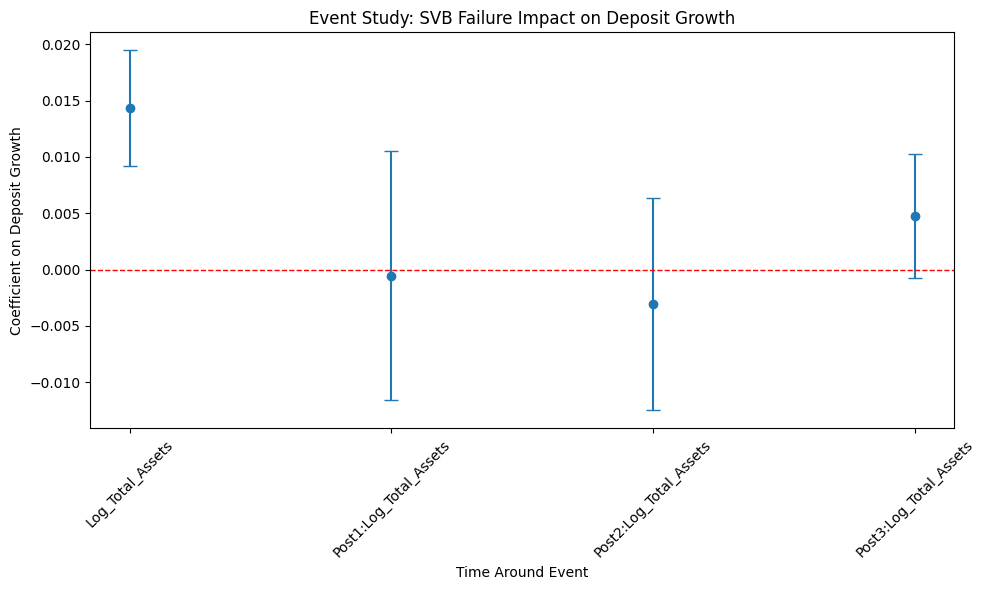

In [ ]:
results_df = pd.DataFrame({
    'term': model_dynamic.params.index,
    'coefficient': model_dynamic.params.values,
    'std_error': model_dynamic.bse.values
})
results_df = results_df[results_df['term'].str.contains('Log_Total_Assets')]

# Add confidence intervals
results_df['ci_lower'] = results_df['coefficient'] - 1.96 * results_df['std_error']
results_df['ci_upper'] = results_df['coefficient'] + 1.96 * results_df['std_error']

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.errorbar(
    results_df['term'], results_df['coefficient'], 
    yerr=1.96 * results_df['std_error'], fmt='o', capsize=5
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Event Study: SVB Failure Impact on Deposit Growth')
plt.xlabel('Time Around Event')
plt.ylabel('Coefficient on Deposit Growth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()